In [1]:
%load_ext autoreload

In [13]:
VID_NAMES = ['053113-1', '2013-10-27-part2', '061413-3',
             '2014-06-18-part2', '061713-1', '2014-01-01-part2']

In [2]:
"""
This notebook contains code for drawing face-detected and random samples from a video, 
annotating on face/no face, and calculating precision, recall, and F-score.
"""

import pandas as pd
import cv2
import os
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import ntpath
from collections import defaultdict

from detector import FaceDetector
from sample_processing import (create_sample_json, annotate_sample, run_detector_on_sample,
                               incorporate_openpose_output, calc_prf, display_prf, display_prf2)

%autoreload 2
!which python # should be /home/users/agrawalk/miniconda2/envs/headcam/bin/python

/home/users/agrawalk/miniconda2/envs/headcam/bin/python


In [32]:
#1. Extract frames with ffmpeg
SCRATCH = os.path.expandvars('$SCRATCH')
VID_NAMES = ['053113-1', '2013-10-27-part2', '061413-3',
             '2014-06-18-part2', '061713-1', '2014-01-01-part2']
VID_PATHS = [os.path.join(SCRATCH, 'testvideos', f'{vid_name}.AVI') 
             for vid_name in VID_NAMES]

#TODO: make nicer sbatch wrapper in python
cmd = ('sbatch -p normal,hns -t 1:30:00 '
       '--mail-type=FAIL --mail-user=agrawalk@stanford.edu '
       '--wrap="python extract_frames.py {}"')

for vid_path in VID_PATHS[:3]:
    p = subprocess.Popen(cmd.format(vid_path), shell=True, 
                         stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    print(p.communicate())

(b'Submitted batch job 38858098\n', b'')
(b'Submitted batch job 38858099\n', b'')
(b'Submitted batch job 38858100\n', b'')


In [2]:
!squeue -u $USER

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)


In [ ]:
#2. Run MTCNN on 10000 frames of each video
#TODO: add case to check if output json exists, and ask for confirmation to overwrite
MASTER_JSON_PATH = os.path.join(SCRATCH, 'headcam-algo', 'gold_set.json')
OUTPUT = os.path.join(SCRATCH, 'headcam_algo', 'output'
FRAME_DIRS = [os.path.join(OUTPUT, f'{vid_name}_frames') for vid_name in VID_NAMES]

cmd = ('sbatch -p normal,hns -c 8 -t 1:30:00 '
       '--mail-type=FAIL --mail-user=agrawalk@stanford.edu '
       '--wrap="python detect_faces_simple.py {0} {1}"')
                      
for frame_dir in FRAME_DIRS:
    p = subprocess.Popen(cmd.format(frame_dir, MASTER_JSON_PATH), shell=True, 
                         stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    print(p.communicate())

In [ ]:
#3. select a random sample of 200 face-detected, 200 random frames from each video in the dataframe
#e.g. if 6 videos in JSON, creates a sample dataframe of size (200 + 200)*6 = 2400 frames
#TODO: add case to check if output json exists, and ask for confirmation to overwrite
SAMPLE_JSON_PATH = os.path.join(SCRATCH, 'headcam-algo', 'gold_set_sample.json')

create_sample_json(MASTER_JSON_PATH, SAMPLE_JSON_PATH, sample_size=200)

In [ ]:
#4a. run + add detections for additional detectors to sample dataframe.

for det_name in ['vj']:
    run_detector_on_sample(det_name, FRAMES_DIR, SAMPLE_JSON_PATH)

In [ ]:
#4b. Hand-annotate for face (y/n) on the sample. Save annotations to dataframe.
#TODO: add case to check if annotation column exists, and ask for confirmation to overwrite
annotate_frames(OUTPUT, SAMPLE_JSON_PATH)

In [ ]:
#5a. Run openpose on videos
OPENPOSE_OUTPUT = os.path.join(SCRATCH, 'headcam-algo', 'openpose_json_output')

cmd = ('sbatch -p gpu --gres gpu:1 -t 5:00:00 --mem 8G '
       '--mail-type=FAIL --mail-user=agrawalk@stanford.edu '
       '--wrap="singularity exec --nv $SINGULARITY_CACHEDIR/openpose-latest.img bash -c '
       '\'cd /openpose-master && ./build/examples/openpose/openpose.bin '
       '--no_display true '
       '--render_pose 0 '
       '--video {0} '
       '--frame_rotate 180 '
       '--face ' # maybe don't want this
       '--hand ' # probably don't want this
       '--write_keypoint_json {1}\'"')

for vid_path in VID_PATHS:
    openpose_vid_output = os.path.join(OPENPOSE_OUTPUT, ntpath.basename(vid_path)[:-4])
    #TODO: add case to check if output dir exists, and ask for confirmation to overwrite
    p = subprocess.Popen(cmd.format(vid_path, openpose_vid_output), shell=True, 
                             stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    print(p.communicate()) #Output of job submission command

In [ ]:
#5b. add columns to the dataframe for the openpose keypoints
#TODO: add case to check if openpose column exists, and ask for confirmation to overwrite
incorporate_openpose_output(SAMPLE_JSON_PATH, OPENPOSE_DIR)

In [2]:
SAMPLE_JSON_PATH  = '/scratch/users/agrawalk/headcam-algo/tests/gold_set_sample.json'
display_prf(SAMPLE_JSON_PATH)

DETECTOR: vj
	GROUP: face (1200 frames)
	precision: 0.94, recall: 0.39, F1: 0.55

	VID: 053113-1 (200 frames)
	precision: 0.89, recall: 0.65, F1: 0.75

	VID: 2014-06-18-part2 (200 frames)
	precision: 0.4, recall: 0.03, F1: 0.05

	VID: 061413-3 (200 frames)
	precision: 1.0, recall: 0.55, F1: 0.71

	VID: 2013-10-27-part2 (200 frames)
	precision: 0.98, recall: 0.4, F1: 0.56

	VID: 061713-1 (200 frames)
	precision: 0.94, recall: 0.2, F1: 0.32

	VID: 2014-01-01-part2 (200 frames)
	precision: 0.85, recall: 0.35, F1: 0.5

	GROUP: random (1200 frames)
	precision: 0.69, recall: 0.15, F1: 0.25

	VID: 053113-1 (200 frames)
	precision: 0.47, recall: 0.25, F1: 0.33

	VID: 2014-06-18-part2 (200 frames)
	precision: 0.0, recall: 0.0, F1: 0.0

	VID: 061413-3 (200 frames)
	precision: 0.93, recall: 0.25, F1: 0.39

	VID: 2013-10-27-part2 (200 frames)
	precision: 0.65, recall: 0.22, F1: 0.33

	VID: 061713-1 (200 frames)
	precision: 0.83, recall: 0.06, F1: 0.11

	VID: 2014-01-01-part2 (200 frames)
	precisio

In [2]:
SAMPLE_JSON_PATH  = '/scratch/users/agrawalk/headcam-algo/tests/gold_set_sample.json'
display_prf2(SAMPLE_JSON_PATH)

VID: 053113-1 (400 frames)
	DETECTOR: vj
	[face] precision: 0.89, recall: 0.65, F1: 0.75

	[random] precision: 0.47, recall: 0.25, F1: 0.33


	DETECTOR: mtcnn
	[face] precision: 0.54, recall: 1.0, F1: 0.7

	[random] precision: 0.4, recall: 0.57, F1: 0.47


	DETECTOR: openpose
	[face] precision: 0.79, recall: 1.0, F1: 0.88

	[random] precision: 0.26, recall: 0.89, F1: 0.41


VID: 2014-06-18-part2 (400 frames)
	DETECTOR: vj
	[face] precision: 0.4, recall: 0.03, F1: 0.05

	[random] precision: 0.0, recall: 0.0, F1: 0.0


	DETECTOR: mtcnn
	[face] precision: 0.38, recall: 1.0, F1: 0.55

	[random] precision: 0.58, recall: 0.31, F1: 0.4


	DETECTOR: openpose
	[face] precision: 0.7, recall: 0.97, F1: 0.82

	[random] precision: 0.44, recall: 0.94, F1: 0.6


VID: 061413-3 (400 frames)
	DETECTOR: vj
	[face] precision: 1.0, recall: 0.55, F1: 0.71

	[random] precision: 0.93, recall: 0.25, F1: 0.39


	DETECTOR: mtcnn
	[face] precision: 0.98, recall: 1.0, F1: 0.99

	[random] precision: 0.95, recall: 0

In [14]:
#6. Visualize detector scores

#Face/Random -> P/R/F -> Detector -> Video

df = pd.read_json('gold_set_sample.json')
print(len(df[df.index >= 1200]), len(df[df.index < 1200]))
groups = {'random' : df[df.index < 1200], 'face' : df[df.index >= 1200]}


#group by detector, then pairwise 
p = defaultdict(list)
r = defaultdict(list)
f = defaultdict(list)

p_vids = defaultdict(list)
r_vids = defaultdict(list)
f_vids = defaultdict(list)
det_names = ['mtcnn', 'vj', 'openpose']

for group in groups:
    for det in det_names:
        cut = groups[group]
        prf = calc_prf(cut, det)
        p[det].append(prf[0])
        r[det].append(prf[1])
        f[det].append(prf[2])
        
        prf_vids = [calc_prf(cut[cut['vid_name'] == vid_name], det) for vid_name in VID_NAMES]
        p_vids[det].append([x[0] for x in prf_vids])
        r_vids[det].append([x[1] for x in prf_vids])
        f_vids[det].append([x[2] for x in prf_vids])
        

1200 1200


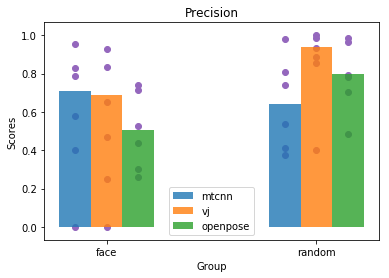

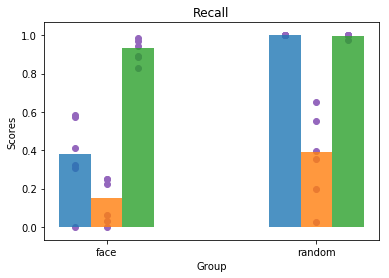

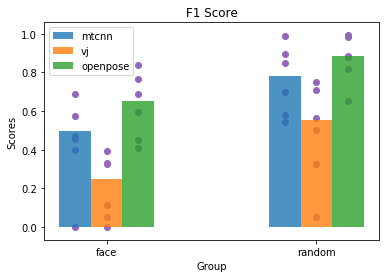

In [23]:
fig, ax = plt.subplots()
index = np.arange(2)
bar_width = 0.15
opacity = 0.8

colors = ['C0', 'C1', 'C2', 'C3']

f1 = plt.figure(1)

for i, det in enumerate(det_names):
    x = index + i*bar_width
    plt.bar(x, p[det], bar_width,
            alpha=opacity,
            color=colors[i],
            label=det)
    for i in range(len(index)):
        plt.scatter([x[i] for _ in range(len(p_vids[det][i]))], p_vids[det][i], color='C4')

plt.xlabel('Group')
plt.ylabel('Scores')
plt.title('Precision')
plt.xticks(index + bar_width, ('face', 'random'))
plt.legend()

f2 = plt.figure(2)
for i, det in enumerate(det_names):
    x = index + i*bar_width
    plt.bar(x, r[det], bar_width,
            alpha=opacity,
            color=colors[i],
            label=det)
    for i in range(len(index)):
        plt.scatter([x[i] for _ in range(len(r_vids[det][i]))], r_vids[det][i], color='C4')

plt.xlabel('Group')
plt.ylabel('Scores')
plt.title('Recall')

plt.xticks(index + bar_width, ('face', 'random'))

f3 = plt.figure(3)
for i, det in enumerate(det_names):
    x = index + i*bar_width
    plt.bar(x, f[det], bar_width,
            alpha=opacity,
            color=colors[i],
            label=det)
    for i in range(len(index)):
        plt.scatter([x[i] for _ in range(len(f_vids[det][i]))], f_vids[det][i], color='C4')

plt.xlabel('Group')
plt.ylabel('Scores')
plt.title('F1 Score')

plt.xticks(index + bar_width, ('face', 'random'))
plt.legend()
    
plt.show()
# vid_prfs = [calc_prf(cut[cut['vid_name'] == vid_name]) for vid_name in VID_NAMES]

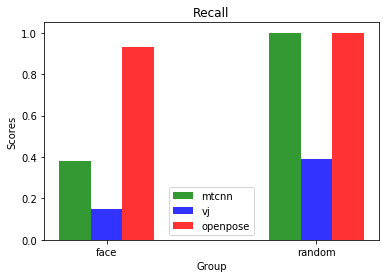

In [37]:
for i, det in enumerate(det_names):
    x = index + i*bar_width
    rects.append(plt.bar(x, r[det], bar_width,
                         alpha=opacity,
                         color=colors[i],
                         label=det))
    
plt.xlabel('Group')
plt.ylabel('Scores')
plt.title('Recall')
plt.xticks(index + bar_width, ('face', 'random'))
plt.legend()
    
plt.show()

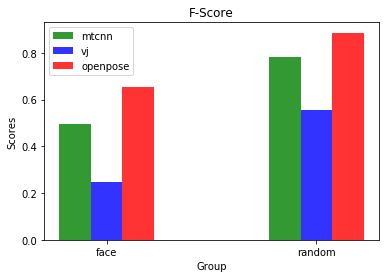

In [38]:
for i, det in enumerate(det_names):
    x = index + i*bar_width
    rects.append(plt.bar(x, f[det], bar_width,
                         alpha=opacity,
                         color=colors[i],
                         label=det))

plt.xlabel('Group')
plt.ylabel('Scores')
plt.title('F-Score')
plt.xticks(index + bar_width, ('face', 'random'))
plt.legend()
    
plt.show()

In [ ]:
#7. Visualize frames which Openpose succeeds and MTCNN fails.